In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Analyse training

best_epoch = 14, floor_best_epoch = 10
best accuracy:  90.291259765625


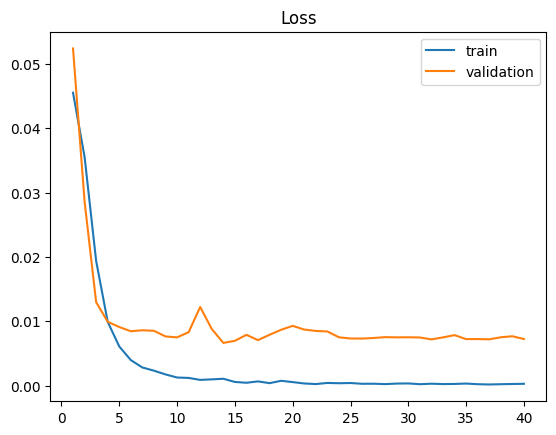

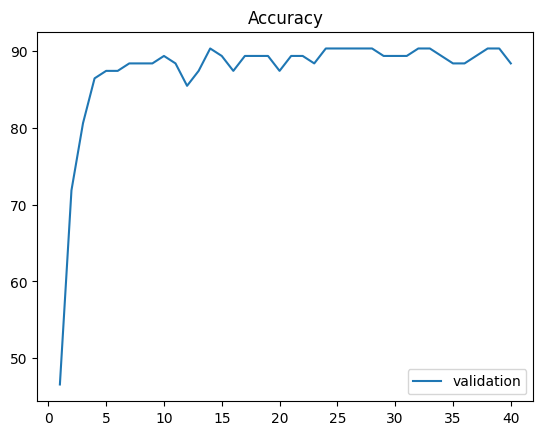

In [2]:
path = 'train_loss_tab.csv'
path = 'res50_fcMLP_trainall_40epochs_lr0dot00001_augmix_rcnn/train_loss_tab.csv'
df = pd.read_csv(path)

best_epoch = df['val_loss'].argmin()+1
floor_best_epoch = 10 * (best_epoch//10)
ceil_best_epoch = 10 * (best_epoch//10 + 1)
print(f"{best_epoch = }, {floor_best_epoch = }")
print("best accuracy: ", df['val_acc'].max())
#print(df['val_loss'][best_epoch-1], df['val_loss'][floor_best_epoch-1], df['val_loss'][ceil_best_epoch-1])
#print(df['val_acc'][best_epoch-1], df['val_acc'][floor_best_epoch-1], df['val_acc'][ceil_best_epoch-1])

plt.plot(df['epoch'],df['train_loss'],label='train')
plt.plot(df['epoch'],df['val_loss'],label='validation')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(df['epoch'],df['val_acc'],label='validation')
plt.legend()
plt.title("Accuracy")
plt.show()